Jupyter Notebook Analysis of UIUC grades data
=============================================
*dataset acquired from a FOIA request*

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
FILENAME = './data/Fall_2015.csv'

Cleaning
--------
* Read, clean, and add  'Enrollment' column
* Reindex by subject and number

In [2]:
# Load and clean dataset
df = pd.read_csv(FILENAME).dropna()
drops = ['CRN', 'Term', 'Sched Type', 'Course Section', 'Primary Instructor', 'W']
df = df.drop(drops, 1)

# Create 'Enrollment' column
df.loc[:, 'A+':'F'] = df.loc[:, 'A+':'F'].astype(int)
df.insert(
    df.columns.get_loc('Average Grade'),
    'Enrollment',
    df.loc[:, 'A+':'F'].sum(axis=1)
)

In [3]:
# Subindex by 'Course Subject' then 'Course Number'
by_number = df.set_index(['Course Subject', 'Course Number'])
by_number.head()

Course Title  Enrollment  \
Course Subject Course Number                                               
AAS            100              Intro Asian American Studies          25   
               100              Intro Asian American Studies          28   
               215              US Citizenship Comparatively          29   
ABE            100            Intro Agric & Biological Engrg          40   
               199               Water in the Global Environ          21   

                              Average Grade  A+   A  A-  B+   B  B-  C+  C  \
Course Subject Course Number                                                 
AAS            100                     3.72   0  19   1   2   1   1   0  0   
               100                     3.47   1  13   5   1   3   3   1  0   
               215                     2.81   1   3   5   4   1   6   1  3   
ABE            100                     3.63   0  27   0   0  11   0   0  2   
               199                     3.97   2  18   0   1   0   0   0  0   

                              C-  D+  D  D-  F  
Course Subject Course Number                    
AAS            100             0   0  1   0  0  
               100             0   0  0   0  1  
               215             2   1  1   1  0  
ABE            100             0   0  0   0  0  
               199             0   0  0   0  0

Plotting
--------
* Create course plotting function
* Make plots for different courses

In [4]:
# Creates a nice plot of a course grade distribution
def plot_course_num(course, name, number):
    grades = course.loc[:, 'A+':'F']
    weighted_avg = np.ma.average(course['Average Grade'], weights=course['Enrollment'])
    highest = grades.values.max()
    
    grades.T.plot.bar(
        ylim=(0, int(highest*1.1)+1),
        legend=False,
        title='{0} {1} Grades'.format(name, number)
    )
    plt.xlabel('Letter Grade')
    plt.ylabel('Number of Students')
    plt.text(
        7.75, highest*0.95,
        'Average GPA: %0.2f' % weighted_avg.round(2),
        fontsize=12
    )

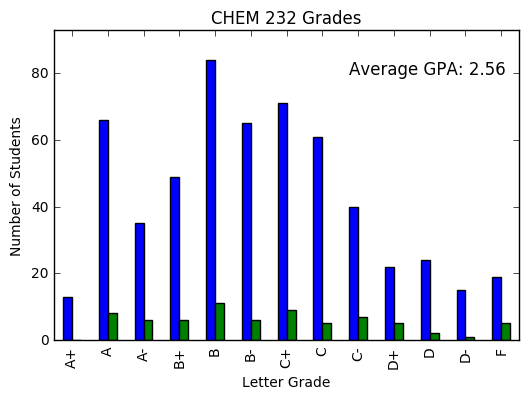

In [5]:
course = 'CHEM 232'

subject, number = course.split()
plot_course_num(
    by_number.loc[subject].loc[[int(number)]],
    subject,
    int(number)
)

More restructuring of data
--------------------------
* Join duplicate courses
* Calculate GPA for entire course, not just sections
* Join all courses from majors to get department GPA

In [6]:
enroll = pd.concat((
    by_number['Enrollment'],
    by_number['Average Grade'],
    by_number.loc[:, 'A+':'F']
), axis=1)

# Creating 'Course GPA'
# Summing 'Enrollment' and 'A+':'F'
groups = enroll.groupby(level=[0,1])
courses = (
    groups
    .apply(
        lambda d: np.ma.average(
            d['Average Grade'], weights=d['Enrollment']
        ).round(2)
    )
    .to_frame('Course GPA')
    .join(
        groups.sum().loc[:, ['Enrollment']]
    )
    .join(
        groups.sum().loc[:, 'A+':'F']
    )
)

In [7]:
courses.head()

Course GPA  Enrollment  A+   A  A-  B+   B  B-  \
Course Subject Course Number                                                   
AAS            100                  3.59          53   1  32   6   3   4   4   
               215                  2.81          29   1   3   5   4   1   6   
ABE            100                  3.63          40   0  27   0   0  11   0   
               199                  3.97          21   2  18   0   1   0   0   
               223                  3.50          63   1  29   9  10   7   0   

                              C+  C  C-  D+  D  D-  F  
Course Subject Course Number                           
AAS            100             1  0   0   0  1   0  1  
               215             1  3   2   1  1   1  0  
ABE            100             0  2   0   0  0   0  0  
               199             0  0   0   0  0   0  0  
               223             4  1   0   1  0   1  0

In [8]:
subjects = ['PHYS']
courses.loc[subjects].sort_values(by='Course GPA').head()

Course GPA  Enrollment   A+    A  A-  B+   B  \
Course Subject Course Number                                                 
PHYS           213                  2.54         497   35   60  32  46  39   
               214                  2.67         563   52   58  33  59  62   
               212                  2.67        1097  160  108  84  89  76   
               486                  2.68          83    5    7   8  10  11   
               101                  2.72         418   54   58  26  31  29   

                               B-   C+   C  C-  D+   D  D-   F  
Course Subject Course Number                                    
PHYS           213             59   42  45  37  28  31  29  14  
               214             58   65  53  35  35  25  22   6  
               212            100  107  93  90  62  50  54  24  
               486              9   12   4   5   3   4   4   1  
               101             46   41  43  27  19  19  15  10

In [9]:
groups = courses.groupby(level=0)

* Join all course numbers

In [10]:
# Another weighted average but now grouping by major

groups = courses.groupby(level=0)

all_enroll = groups.sum()['Enrollment']

all_gpa = (
    groups
    .apply(
        lambda d: np.ma.average(
            d['Course GPA'], weights=d['Enrollment']
        ).round(2)
    )
    .to_frame('Major GPA')
)

course_freq = pd.value_counts(
    np.asarray(courses.index.tolist())[:, 0]
).to_frame('# Courses')

by_subject = pd.concat([
    all_enroll,
    all_gpa,
    course_freq
], axis=1)

In [11]:
by_subject.head()

,Enrollment,Major GPA,# Courses
AAS,82,3.31,2
ABE,375,3.73,7
ACCY,4083,3.34,27
ACE,2280,3.33,25
ACES,416,3.66,2


* Browse courses
* Demo plot of GPA comparison

,Enrollment,Major GPA,# Courses
ABE,375,3.73,7
BIOE,518,3.60,9
NPRE,548,3.48,9
GE,621,3.46,11
AE,1010,3.42,11
CEE,2802,3.42,40
ME,2157,3.38,24
CS,7805,3.29,38
MSE,1272,3.27,23
ECE,5235,3.12,50


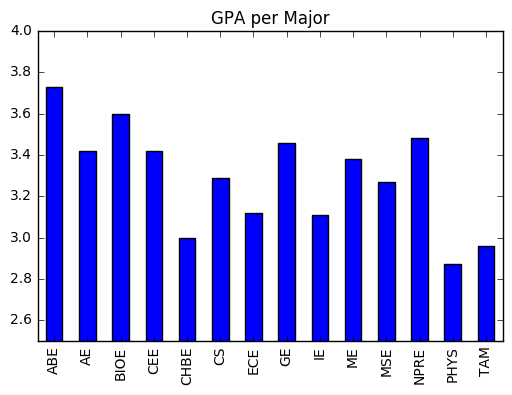

In [12]:
eng_courses = ['ABE', 'AE', 'BIOE', 'CEE', 'CHBE', 'CS', 'ECE',
               'GE', 'IE', 'ME', 'MSE', 'NPRE', 'PHYS', 'TAM']
eng = by_subject.loc[eng_courses]
eng['Major GPA'].plot.bar(
    ylim=2.5,
    title='GPA per Major'
)
eng.sort_values(by=['Major GPA'], ascending=False)